In [1]:
# import the necessaey modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.contrib.layers import xavier_initializer

%matplotlib inline

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data', one_hot=True)

# define hyperparameters
batch_size = 128
Z_dim = 100
im_size = 28
h_size=128
learning_rate_D = .0005
learning_rate_G = .0006


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#Create Placeholder for input X and random noise Z
X = tf.placeholder(tf.float32, shape=[None, im_size*im_size])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
initializer=xavier_initializer()

# Define Discriminator and Generator training variables

#Discriminiator
D_W1 = tf.Variable(initializer([im_size*im_size, h_size]))
D_b1 = tf.Variable(tf.zeros(shape=[h_size]))

D_W2 = tf.Variable(initializer([h_size, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

#Generator
G_W1 = tf.Variable(initializer([Z_dim, h_size]))
G_b1 = tf.Variable(tf.zeros(shape=[h_size]))

G_W2 = tf.Variable(initializer([h_size, im_size*im_size]))
G_b2 = tf.Variable(tf.zeros(shape=[im_size*im_size]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [4]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    """ Two layer Generator Network Z=>128=>784 """
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    """ Two layer Discriminator Network X=>128=>1 """
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot(samples):
    "function to plot generated samples"
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig


In [5]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate_D).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate_G).minimize(G_loss, var_list=theta_G)


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
GLoss = []
DLoss = []

if not os.path.exists('out/'):
    os.makedirs('out/')

for it in range(100000):
    if it % 100 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(25, Z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
        plt.close(fig)

    X_mb, _ = data.train.next_batch(batch_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    GLoss.append(G_loss_curr)
    DLoss.append(D_loss_curr)

    if it % 100 == 0:
        print('Iter: {} D loss: {:.4} G_loss: {:.4}'.format(it,D_loss_curr, G_loss_curr))
        
print('Done')

Iter: 0 D loss: 1.085 G_loss: 1.998
Iter: 100 D loss: 0.08578 G_loss: 5.416
Iter: 200 D loss: 0.3299 G_loss: 3.09
Iter: 300 D loss: 0.2034 G_loss: 3.862
Iter: 400 D loss: 0.08722 G_loss: 4.015
Iter: 500 D loss: 0.0238 G_loss: 4.706
Iter: 600 D loss: 0.03654 G_loss: 4.905
Iter: 700 D loss: 0.03494 G_loss: 4.825
Iter: 800 D loss: 0.02324 G_loss: 5.374
Iter: 900 D loss: 0.01525 G_loss: 5.616
Iter: 1000 D loss: 0.05434 G_loss: 5.536
Iter: 1100 D loss: 0.02404 G_loss: 5.85
Iter: 1200 D loss: 0.02222 G_loss: 5.645
Iter: 1300 D loss: 0.04074 G_loss: 6.221
Iter: 1400 D loss: 0.02187 G_loss: 7.705
Iter: 1500 D loss: 0.01162 G_loss: 7.475
Iter: 1600 D loss: 0.02001 G_loss: 6.783
Iter: 1700 D loss: 0.0304 G_loss: 5.056
Iter: 1800 D loss: 0.04932 G_loss: 4.444
Iter: 1900 D loss: 0.1955 G_loss: 3.668
Iter: 2000 D loss: 0.1255 G_loss: 3.648
Iter: 2100 D loss: 0.1186 G_loss: 4.202
Iter: 2200 D loss: 0.08755 G_loss: 4.632
Iter: 2300 D loss: 0.02271 G_loss: 5.845
Iter: 2400 D loss: 0.02847 G_loss: 5.70

Iter: 20400 D loss: 0.6668 G_loss: 2.008
Iter: 20500 D loss: 0.7854 G_loss: 1.732
Iter: 20600 D loss: 0.7713 G_loss: 2.296
Iter: 20700 D loss: 0.7764 G_loss: 2.038
Iter: 20800 D loss: 0.7515 G_loss: 1.832
Iter: 20900 D loss: 0.7285 G_loss: 2.079
Iter: 21000 D loss: 0.7964 G_loss: 1.952
Iter: 21100 D loss: 0.713 G_loss: 1.893
Iter: 21200 D loss: 0.6619 G_loss: 1.937
Iter: 21300 D loss: 0.7075 G_loss: 2.04
Iter: 21400 D loss: 0.5833 G_loss: 1.867
Iter: 21500 D loss: 0.8153 G_loss: 2.214
Iter: 21600 D loss: 0.7344 G_loss: 1.98
Iter: 21700 D loss: 0.7672 G_loss: 1.982
Iter: 21800 D loss: 0.7236 G_loss: 1.928
Iter: 21900 D loss: 0.7126 G_loss: 1.9
Iter: 22000 D loss: 0.8475 G_loss: 1.785
Iter: 22100 D loss: 0.6677 G_loss: 2.229
Iter: 22200 D loss: 0.7141 G_loss: 1.692
Iter: 22300 D loss: 0.843 G_loss: 2.114
Iter: 22400 D loss: 0.6722 G_loss: 2.32
Iter: 22500 D loss: 0.7872 G_loss: 2.13
Iter: 22600 D loss: 0.8489 G_loss: 1.942
Iter: 22700 D loss: 0.6893 G_loss: 2.118
Iter: 22800 D loss: 0.74

Iter: 40500 D loss: 0.7319 G_loss: 2.221
Iter: 40600 D loss: 0.733 G_loss: 2.174
Iter: 40700 D loss: 0.9048 G_loss: 1.967
Iter: 40800 D loss: 0.733 G_loss: 1.988
Iter: 40900 D loss: 0.7015 G_loss: 1.969
Iter: 41000 D loss: 0.756 G_loss: 2.02
Iter: 41100 D loss: 0.821 G_loss: 1.945
Iter: 41200 D loss: 0.7889 G_loss: 1.853
Iter: 41300 D loss: 0.7453 G_loss: 2.048
Iter: 41400 D loss: 0.802 G_loss: 1.8
Iter: 41500 D loss: 0.7953 G_loss: 1.904
Iter: 41600 D loss: 0.8211 G_loss: 2.076
Iter: 41700 D loss: 0.722 G_loss: 2.17
Iter: 41800 D loss: 0.8333 G_loss: 2.002
Iter: 41900 D loss: 0.808 G_loss: 2.045
Iter: 42000 D loss: 0.8284 G_loss: 1.954
Iter: 42100 D loss: 0.8924 G_loss: 2.019
Iter: 42200 D loss: 0.7023 G_loss: 1.992
Iter: 42300 D loss: 0.7849 G_loss: 1.956
Iter: 42400 D loss: 0.7037 G_loss: 1.938
Iter: 42500 D loss: 0.747 G_loss: 1.932
Iter: 42600 D loss: 0.7167 G_loss: 2.125
Iter: 42700 D loss: 0.6287 G_loss: 1.891
Iter: 42800 D loss: 0.6966 G_loss: 2.021
Iter: 42900 D loss: 0.6768 G

Iter: 60700 D loss: 0.6725 G_loss: 2.451
Iter: 60800 D loss: 0.7517 G_loss: 2.092
Iter: 60900 D loss: 0.71 G_loss: 1.918
Iter: 61000 D loss: 0.5811 G_loss: 2.332
Iter: 61100 D loss: 0.6033 G_loss: 2.156
Iter: 61200 D loss: 0.5755 G_loss: 2.387
Iter: 61300 D loss: 0.6076 G_loss: 2.023
Iter: 61400 D loss: 0.7276 G_loss: 2.301
Iter: 61500 D loss: 0.6081 G_loss: 2.191
Iter: 61600 D loss: 0.7032 G_loss: 2.358
Iter: 61700 D loss: 0.6749 G_loss: 2.325
Iter: 61800 D loss: 0.6433 G_loss: 2.353
Iter: 61900 D loss: 0.5758 G_loss: 2.051
Iter: 62000 D loss: 0.7596 G_loss: 2.006
Iter: 62100 D loss: 0.5082 G_loss: 2.54
Iter: 62200 D loss: 0.5943 G_loss: 2.14
Iter: 62300 D loss: 0.6515 G_loss: 2.279
Iter: 62400 D loss: 0.5787 G_loss: 2.34
Iter: 62500 D loss: 0.6606 G_loss: 2.274
Iter: 62600 D loss: 0.6284 G_loss: 2.124
Iter: 62700 D loss: 0.6721 G_loss: 2.156
Iter: 62800 D loss: 0.5953 G_loss: 2.027
Iter: 62900 D loss: 0.6638 G_loss: 2.217
Iter: 63000 D loss: 0.5885 G_loss: 2.154
Iter: 63100 D loss: 0

Iter: 80800 D loss: 0.7482 G_loss: 2.621
Iter: 80900 D loss: 0.5799 G_loss: 2.689
Iter: 81000 D loss: 0.6268 G_loss: 2.521
Iter: 81100 D loss: 0.531 G_loss: 2.191
Iter: 81200 D loss: 0.5896 G_loss: 2.655
Iter: 81300 D loss: 0.5448 G_loss: 2.359
Iter: 81400 D loss: 0.5559 G_loss: 2.549
Iter: 81500 D loss: 0.5732 G_loss: 2.089
Iter: 81600 D loss: 0.5246 G_loss: 2.824
Iter: 81700 D loss: 0.6573 G_loss: 2.766
Iter: 81800 D loss: 0.5004 G_loss: 2.397
Iter: 81900 D loss: 0.4493 G_loss: 2.574
Iter: 82000 D loss: 0.5257 G_loss: 2.336
Iter: 82100 D loss: 0.5204 G_loss: 2.346
Iter: 82200 D loss: 0.5772 G_loss: 2.417
Iter: 82300 D loss: 0.6483 G_loss: 2.724
Iter: 82400 D loss: 0.5943 G_loss: 2.559
Iter: 82500 D loss: 0.4879 G_loss: 2.586
Iter: 82600 D loss: 0.5521 G_loss: 2.616
Iter: 82700 D loss: 0.4569 G_loss: 2.535
Iter: 82800 D loss: 0.517 G_loss: 2.668
Iter: 82900 D loss: 0.5905 G_loss: 2.636
Iter: 83000 D loss: 0.624 G_loss: 2.698
Iter: 83100 D loss: 0.5227 G_loss: 2.55
Iter: 83200 D loss: 

Text(0,0.5,'Loss')

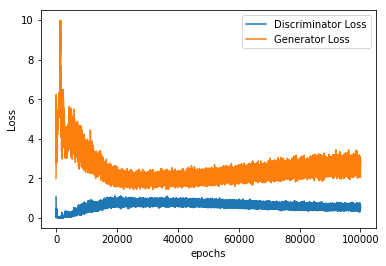

In [7]:
plt.plot(DLoss, label = 'Discriminator Loss')
plt.plot(GLoss, label = 'Generator Loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')